<a href="https://colab.research.google.com/github/Aman-Singh-Akhand/QML-HEP-GSoC-2025/blob/main/Task_VII_Equivariant_quantum_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def generate_z2x2_symmetric_dataset(n_base_points=500):
    # Step 1: Generate base points (x1, x2 in 1st quadrant)
    x_base = np.random.uniform(low=0.1, high=1.0, size=(n_base_points, 2))

    # Step 2: Define a classification rule
    # Example: points inside circle are class 0, outside are class 1
    labels = np.linalg.norm(x_base, axis=1) < 0.75  # circle radius
    labels = labels.astype(int)

    # Step 3: Apply Z2 x Z2 symmetry transformations
    def apply_symmetries(x):
        x1, x2 = x
        return np.array([
            [x1, x2],
            [-x1, x2],
            [x1, -x2],
            [-x1, -x2],
            [x2, x1],
            [-x2, x1],
            [x2, -x1],
            [-x2, -x1]
        ])

    all_points = []
    all_labels = []

    for point, label in zip(x_base, labels):
        sym_points = apply_symmetries(point)
        all_points.append(sym_points)
        all_labels.append(np.full(len(sym_points), label))

    X = np.vstack(all_points)
    y = np.concatenate(all_labels)

    # Step 4: Deduplicate points
    data = np.hstack((X, y[:, np.newaxis]))
    data = np.unique(data, axis=0)
    X_unique = data[:, :2]
    y_unique = data[:, 2].astype(int)

    # Step 5: Shuffle
    X_shuf, y_shuf = shuffle(X_unique, y_unique, random_state=42)

    return X_shuf, y_shuf

# Generate the dataset
X, y = generate_z2x2_symmetric_dataset(n_base_points=1000)




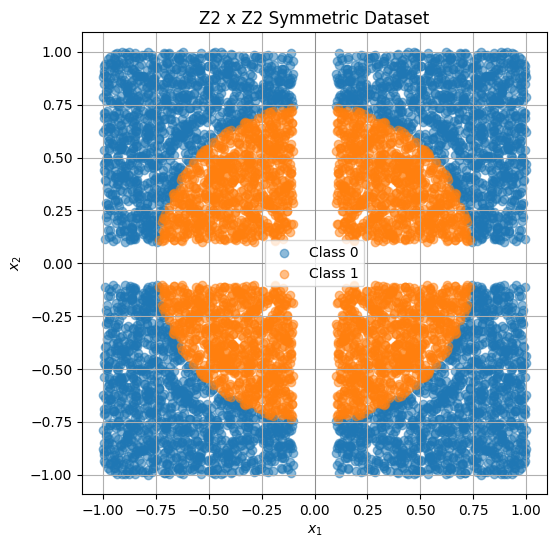

In [4]:
# visualize dataset
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0', alpha=0.5)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1', alpha=0.5)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.title('Z2 x Z2 Symmetric Dataset')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize features for encoding into qubits
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
pip install pennylane scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00


In [15]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# === Quantum circuit parameters ===
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# === Data embedding: Angle encoding ===
def angle_embedding(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)

# === Variational block (can be replaced with more expressive circuits) ===
def variational_block(weights):
    for i in range(n_qubits):
        qml.Rot(*weights[i], wires=i)
    qml.CNOT(wires=[0, 1])

# === QNN model ===
@qml.qnode(dev)
def circuit(x, weights):
    angle_embedding(x)
    variational_block(weights)
    return qml.expval(qml.PauliZ(0))

# === Output function: convert [-1, 1] → [0, 1] ===
def predict(x, weights):
    return (circuit(x, weights) + 1) / 2

# === Cost function ===
def cost(weights, X, y):
    preds = [predict(x, weights) for x in X]
    # Convert preds to a NumPy array with the correct data type
    preds = np.array(preds, dtype=np.float64)
    return np.mean((preds - y) ** 2)

In [16]:
# === Initialize weights ===
np.random.seed(42)
weights_init = np.random.uniform(low=0, high=2 * np.pi, size=(n_qubits, 3), requires_grad=True)



In [18]:
# === Training ===
opt = qml.AdamOptimizer(stepsize=0.1)
weights = weights_init
epochs = 15

for epoch in range(epochs):
    weights = opt.step(lambda w: cost(w, X_train, y_train), weights)
    train_acc = accuracy_score(y_train, np.round([predict(x, weights) for x in X_train]))
    test_acc = accuracy_score(y_test, np.round([predict(x, weights) for x in X_test]))
    print(f"Epoch {epoch+1:2d}: Train Acc = {train_acc:.3f}, Test Acc = {test_acc:.3f}")



Epoch  1: Train Acc = 0.507, Test Acc = 0.531
Epoch  2: Train Acc = 0.517, Test Acc = 0.538
Epoch  3: Train Acc = 0.523, Test Acc = 0.541
Epoch  4: Train Acc = 0.521, Test Acc = 0.540
Epoch  5: Train Acc = 0.511, Test Acc = 0.534
Epoch  6: Train Acc = 0.497, Test Acc = 0.517
Epoch  7: Train Acc = 0.468, Test Acc = 0.480
Epoch  8: Train Acc = 0.463, Test Acc = 0.456
Epoch  9: Train Acc = 0.497, Test Acc = 0.499
Epoch 10: Train Acc = 0.561, Test Acc = 0.571
Epoch 11: Train Acc = 0.571, Test Acc = 0.571
Epoch 12: Train Acc = 0.540, Test Acc = 0.549
Epoch 13: Train Acc = 0.499, Test Acc = 0.502
Epoch 14: Train Acc = 0.488, Test Acc = 0.486
Epoch 15: Train Acc = 0.436, Test Acc = 0.427


In [19]:
# Final accuracy
y_pred = np.round([predict(x, weights) for x in X_test])
print("Final Test Accuracy:", accuracy_score(y_test, y_pred))

Final Test Accuracy: 0.426875


# Equivariant QNN

In [5]:
import pennylane as qml
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# === Set up PennyLane device ===
n_qubits = 2  # Assuming 2 qubits (one for each feature)
dev = qml.device("default.qubit", wires=n_qubits)

# === Define Z₂ × Z₂ equivariant QNN ===
def angle_embedding(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)  # Encode features using Y-rotations

# Define equivariant ansatz
def equivariant_ansatz(weights):
    # Symmetry-respecting gates
    qml.RY(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])  # Swap interaction
    qml.RY(weights[2], wires=0)
    qml.RY(weights[3], wires=1)
    qml.CNOT(wires=[1, 0])  # Symmetric interaction
    qml.RZ(weights[4], wires=0)
    qml.RZ(weights[5], wires=1)

# === QNN model ===
@qml.qnode(dev)
def circuit(x, weights):
    angle_embedding(x)  # Encode data
    equivariant_ansatz(weights)  # Apply equivariant ansatz
    return qml.expval(qml.PauliZ(0))  # Single qubit measurement to predict

# === Cost function ===
def cost(weights, X, y):
    # Evaluate the circuit for each data point and convert to NumPy array
    preds = np.array([circuit(x, weights) for x in X], dtype=object)
    # Flatten the array and convert elements to float using qml.math.unwrap
    preds = np.array([qml.math.unwrap(p) for p in preds.flatten()], dtype=np.float64)

    y = np.array(y, dtype=np.float64)
    return np.mean((preds - y) ** 2)  # Mean squared error (MSE)

In [6]:
# === Initialize weights ===
np.random.seed(42)
weights_init = np.random.uniform(low=0, high=2 * np.pi, size=(6))  # Remove requires_grad
weights_init = qml.numpy.array(weights_init, requires_grad=True) # Convert to PennyLane array with requires_grad



In [7]:
# === Training with PennyLane optimizer ===
opt = qml.AdamOptimizer(stepsize=0.1)
weights = weights_init
epochs = 15

for epoch in range(epochs):
    weights = opt.step(lambda w: cost(w, X_train, y_train), weights)

    # Evaluate accuracy on training and test data
    train_preds = np.round([circuit(x, weights) for x in X_train])
    test_preds = np.round([circuit(x, weights) for x in X_test])

    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)

    print(f"Epoch {epoch+1:2d}: Train Acc = {train_acc:.3f}, Test Acc = {test_acc:.3f}")



/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch  1: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch  2: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch  3: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch  4: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch  5: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch  6: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch  7: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch  8: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch  9: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 10: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 11: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 12: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 13: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 14: Train Acc = 0.565, Test Acc = 0.555


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 15: Train Acc = 0.565, Test Acc = 0.555
